In [12]:
# Importaciones para manejo de datos y dataframes
import numpy as np
from numpy.random import seed
import pandas as pd

# Importaciones para manejo de archivos y llamadas al OS
import os as os
import warnings

# Importaciones para manejo de gráficos
import pylab as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# Sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.neighbors import LocalOutlierFactor

# Metemos un gridsearch
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, classification_report
from collections import Counter
from sklearn.impute import SimpleImputer


from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector,VarianceThreshold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile

# Según el criterio chi-squared dustribution for it to have three features
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import IsolationForest

# No mostrar warnings de versiones anteriores
warnings.filterwarnings('ignore')

In [28]:
# Cargamos csv con los datos de train
df_train = pd.read_csv("../data_raw/training_data.csv", sep=",", header=0, na_values=['?', '', 'NA'])

# Cargamos csv con los datos de test
df_test = pd.read_csv("../data_raw/test_data.csv", sep=",", header=0, na_values=['?', '', 'NA'])

In [29]:
## ENCODING

df_train_num = df_train.copy()
df_test_num = df_test.copy()

# 1. "OrdinalEncoder" para X24
orden_x24 = ['VLOW', 'LOW', 'MED', 'HIGH', 'VHIGH']

ordinal_encoder_x24 = OrdinalEncoder(categories=[orden_x24], dtype=int)

df_train_num['X24'] = ordinal_encoder_x24.fit_transform(df_train_num[['X24']])
df_test_num['X24'] = ordinal_encoder_x24.transform(df_test_num[['X24']])

# 2. "OrdinalEncoder" para X25
orden_x25 = ['NO', 'YES']

ordinal_encoder_x25 = OrdinalEncoder(categories=[orden_x25], dtype=int)

df_train_num['X25'] = ordinal_encoder_x25.fit_transform(df_train_num[['X25']])
df_test_num['X25'] = ordinal_encoder_x25.transform(df_test_num[['X25']])

# Si es VTKGN 1 else 0
# Ya que la la clase está muy desbalanceada
df_train_encoded = df_train_num.copy()
df_test_encoded = df_test_num.copy()

df_train_encoded.loc[df_train_num['X30'] == 'VTKGN', 'X30'] = 1
df_train_encoded.loc[df_train_num['X30'] != 'VTKGN', 'X30'] = 0

df_test_encoded.loc[df_test_num['X30'] == 'VTKGN', 'X30'] = 1
df_test_encoded.loc[df_test_num['X30'] != 'VTKGN', 'X30'] = 0

df_train_encoded['X30'] = pd.to_numeric(df_train_encoded['X30'])
df_test_encoded['X30'] = pd.to_numeric(df_train_encoded['X30']) 

In [30]:
np.random.seed(1234)

df_train = df_train_encoded
df_test = df_test_encoded

# Preprocesamiento para TRAIN
df_final_train = df_train.drop(['ID','RATE'], axis=1, inplace=False)
train_ID = df_train['ID'].copy()
train_RATE = df_train['RATE'].copy()

# Preprocesamiento para TEST
df_final_test = df_test.drop('ID', axis=1, inplace=False)
test_ID = df_test['ID'].copy()

<Axes: xlabel='column', ylabel='value'>

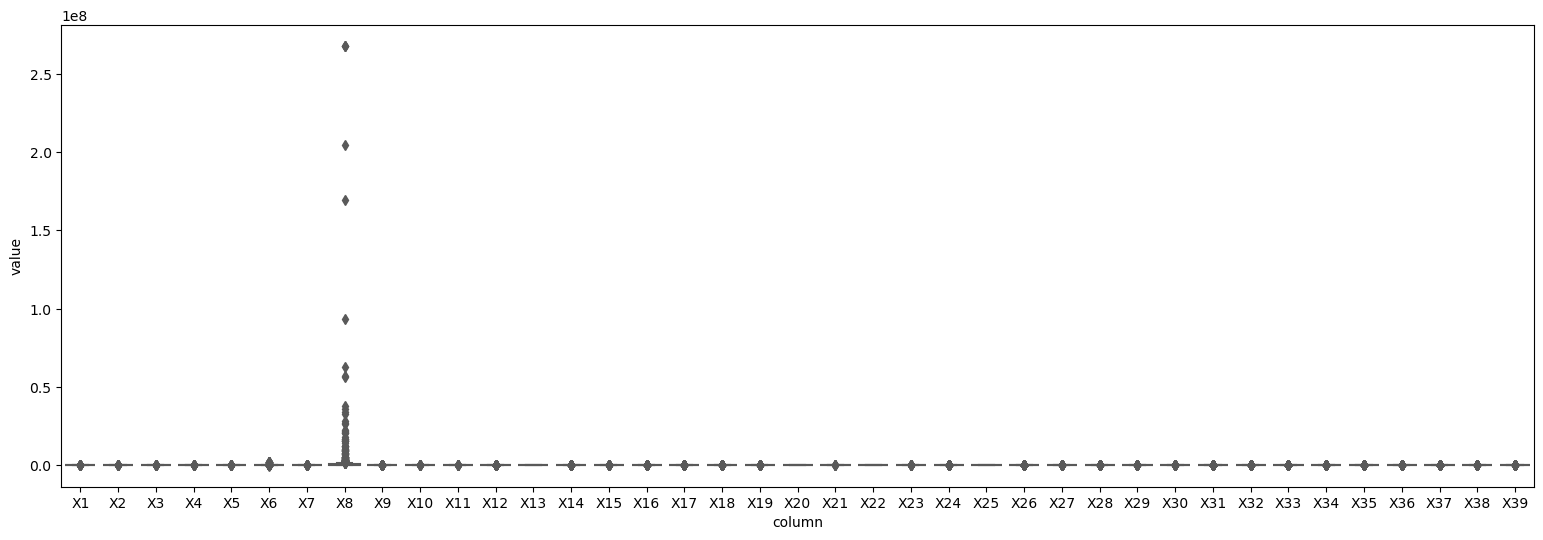

In [31]:
df_train_copy = df_final_train.copy()
df_test_copy = df_final_test.copy()

# Escala raíz cuadrada a las que se dispersan mucho
# df_train_copy[['X1','X2','X3','X4','X5','X7','X10','X11']] = np.sqrt(df_train_copy[['X1','X2','X3','X4','X5','X7','X10','X11']])
# df_test_copy[['X1','X2','X3','X4','X5','X7','X10','X11']] = np.sqrt(df_test_copy[['X1','X2','X3','X4','X5','X7','X10','X11']])

# Escala logarítmica a las que se dispersan mucho
df_train_copy[['X1','X2','X3','X4','X5','X7','X10','X11']] = np.log(df_train_copy[['X1','X2','X3','X4','X5','X7','X10','X11']])
df_test_copy[['X1','X2','X3','X4','X5','X7','X10','X11']] = np.log(df_test_copy[['X1','X2','X3','X4','X5','X7','X10','X11']])

df_melted = df_train_copy.melt(var_name='column')

plt.figure(figsize=(19,6))
sns.boxplot(data=df_melted, color="#3BA3EC", x="column", y="value")

In [32]:
#1. Quitar outliers

modelo_isof = IsolationForest(
                n_estimators  = 1000,
                max_samples   ='auto',
                contamination = 0.1,
                n_jobs        = -1,
                random_state  = 123,
            )

df_no_na = df_train_copy.dropna(axis=0, inplace=False)

modelo_isof.fit(X=df_no_na)
clasificacion_predicha = modelo_isof.predict(X=df_no_na)
clasificacion_predicha

df_no_na['clasificacion_predicha'] = clasificacion_predicha
indices_outliers = df_no_na.index[df_no_na['clasificacion_predicha'] == -1].tolist()

indices_outliers

df_no_outliers = df_train_copy.drop(index=indices_outliers)

# Ahora, imputo sobre el dataset sin outliers
# imp_train = KNNImputer(n_neighbors=5).fit(df_no_outliers)
# df_train_imp = pd.DataFrame(imp_train.transform(df_train_copy), columns=df_train_copy.columns, index=df_train_copy.index)

imp_train = SimpleImputer(missing_values=np.nan, strategy='median').fit(df_no_outliers) #most_frequent
df_train_imp = pd.DataFrame(imp_train.transform(df_train_copy), columns=df_train_copy.columns, index=df_train_copy.index)

# Hago lo mismo para test

modelo_isof_test = IsolationForest(
                n_estimators  = 1000,
                max_samples   ='auto',
                contamination = 0.1,
                n_jobs        = -1,
                random_state  = 123,
            )

df_no_na_test = df_test_copy.dropna(axis=0, inplace=False)

modelo_isof_test.fit(X=df_no_na_test)
clasificacion_predicha = modelo_isof_test.predict(X=df_no_na_test)
clasificacion_predicha

df_no_na_test['clasificacion_predicha'] = clasificacion_predicha
indices_outliers = df_no_na_test.index[df_no_na_test['clasificacion_predicha'] == -1].tolist()

indices_outliers

df_no_outliers_test = df_test_copy.drop(index=indices_outliers)

# imp_test = KNNImputer(n_neighbors=5).fit(df_no_outliers_test)
# df_test_imp = pd.DataFrame(imp_test.transform(df_test_copy), columns=df_test_copy.columns, index=df_test_copy.index)

#Imputamos con mediana

imp_test = SimpleImputer(missing_values=np.nan, strategy='median').fit(df_no_outliers_test)
df_test_imp = pd.DataFrame(imp_test.transform(df_test_copy), columns=df_test_copy.columns, index=df_test_copy.index)

In [33]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_train_imp.to_numpy())
df_scaled = pd.DataFrame(df_scaled,index=df_train_imp.index, columns=[df_train_imp.columns])

df_scaled_test = scaler.transform(df_test_imp.to_numpy())
df_scaled_test = pd.DataFrame(df_scaled_test,index=df_test_imp.index, columns=[df_test_imp.columns])

columns = ['ID']
columns = np.append(columns, df_train_copy.columns)
columns = np.append(columns, 'RATE')

result_df_train = pd.merge(train_ID, df_scaled, left_index=True, right_index=True)
result_df_train = pd.merge(result_df_train, train_RATE, left_index=True, right_index=True)
result_df_train.columns = columns

columns = ['ID']
columns = np.append(columns, df_test_copy.columns)

result_df_test = pd.merge(test_ID, df_scaled_test, left_index=True, right_index=True)
result_df_test.columns = columns

Entrenamiento sin SMOTE

In [34]:
X = result_df_train.drop(['ID','RATE'], inplace=False, axis=1)
y = result_df_train['RATE']

# Dividimos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state = 32, shuffle=True)

# Aplicamos el algoritmo
param_svc = {'C': [0.1, 1, 10, 100, 1000, 10000], 
             'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
             'kernel': ['rbf', 'poly', 'sigmoid', 'linear'],
             'class_weight': ['balanced', None]
             }

SVCM_grid = GridSearchCV(SVC(), param_svc, verbose=1, cv=5, n_jobs=-1, scoring='accuracy')
SVCM_grid.fit(X_train, y_train)

print(f"Mejores parámetros {SVCM_grid.best_estimator_}")
print(f"Acc en GridSearch {SVCM_grid.best_score_}")

y_pred = SVCM_grid.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Acc. en Validación: {acc}\n")

print("Informe completo con búsqueda exhaustiva de parámetros:\n",classification_report(y_test, y_pred))

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Mejores parámetros SVC(C=10000, gamma=0.0001)
Acc en GridSearch 0.667484662576687
Acc. en Validación: 0.5934065934065934

Informe completo con búsqueda exhaustiva de parámetros:
               precision    recall  f1-score   support

           A       0.40      0.29      0.33         7
           B       0.60      0.87      0.71        31
           C       0.58      0.41      0.48        27
           D       0.64      0.54      0.58        26

    accuracy                           0.59        91
   macro avg       0.55      0.53      0.53        91
weighted avg       0.59      0.59      0.58        91



In [24]:
X_final = result_df_test.drop('ID', axis=1, inplace=False)
test_ID = result_df_test['ID'].copy()

y_pred = SVCM_grid.predict(X_final)
df_pred = pd.DataFrame({'ID':test_ID,'TARGET':y_pred})

df_pred.to_csv('../Resultados/prediccion.csv', index=False, sep=',')

Utilizando SMOTE

In [23]:
X = result_df_train.drop(['ID','RATE'], inplace=False, axis=1)
y = result_df_train['RATE']

X_train_split, X_validacion, y_train_split, y_validacion = train_test_split(X, y, test_size=0.3, random_state = 32, shuffle=True)

# for i in np.arange(1,12):
k = 9

# Estrategias de oversampling y undersampling la mayority
over = SMOTE(sampling_strategy = {'A': 110}, k_neighbors=9)
under = RandomUnderSampler(sampling_strategy = {'B': 200})

steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X_resampled, y_resampled = pipeline.fit_resample(X_train_split, y_train_split)

X_resampled = X_resampled
y_resampled = y_resampled

# Aplicamos el algoritmo
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state = 32, shuffle=True)

param_svc = {'C': [0.1, 1, 10, 100, 1000, 10000], 
             'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
             'kernel': ['rbf', 'poly', 'sigmoid', 'linear'],
             'class_weight': ['balanced', None]
             }


SVCM_grid = GridSearchCV(SVC(), param_svc, verbose=1, cv=5, n_jobs=-1, scoring='accuracy')
SVCM_grid.fit(X_train, y_train)

print(f"Mejores parámetros {SVCM_grid.best_estimator_}")
print(f"Acc en GridSearch {SVCM_grid.best_score_}")

#print(f"K value SMOTE {k}")
y_pred = SVCM_grid.predict(X_validacion)

# print("Matriz de confusión:")
# print(confusion_matrix(y_validacion, y_pred))
acc = accuracy_score(y_validacion, y_pred)
print(f"Acc. en Validación: {acc}\n")

print("Informe completo con búsqueda exhaustiva de parámetros:\n",classification_report(y_validacion, y_pred))

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Mejores parámetros SVC(C=1000, class_weight='balanced', gamma=0.001)
Acc en GridSearch 0.6947554697554696
Acc. en Validación: 0.6066176470588235

Informe completo con búsqueda exhaustiva de parámetros:
               precision    recall  f1-score   support

           A       0.48      0.61      0.54        23
           B       0.74      0.62      0.68       112
           C       0.45      0.51      0.48        72
           D       0.68      0.68      0.68        65

    accuracy                           0.61       272
   macro avg       0.59      0.61      0.59       272
weighted avg       0.62      0.61      0.61       272



In [26]:
X_final = result_df_test.drop('ID', axis=1, inplace=False)
test_ID = result_df_test['ID'].copy()

y_pred = SVCM_grid.predict(X_final)
df_pred = pd.DataFrame({'ID':test_ID,'TARGET':y_pred})

df_pred.to_csv('../Resultados/prediccion_smote.csv', index=False, sep=',')